In [ ]:
!pip install spektral

# Prueba con features (variables accesorias) duration y rate, usando LayerPreprocess

### Las próximas celdas son comunes a todos los experimentos 

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import categorical_accuracy #AUC 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from spektral.layers import GINConv,GCNConv #, GCSConv, GlobalAvgPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.data import DisjointLoader, BatchLoader, Dataset, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.transforms.normalize_one import NormalizeOne
from spektral.transforms.normalize_sphere import NormalizeSphere
from spektral.transforms import LayerPreprocess
import gc
import spektral.datasets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from spektral.models.gcn import GCN

#from spektral.transforms import AdjToSpTensor, LayerPreprocess


In [2]:
class CTU13balanced_durRate(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def download(self):
        os.mkdir(self.path)
        
        captures = ["10","11","12","15","15-2","16","16-2","16-3","17","18","18-2","19","15-3"]
        
        # para poder descargar los archivos ncol de cada captura y las features de cada nodo

        features_links = ["ktAgJS22kBXcMsT", 
                          "qfM8pjZgDi9EFfd",
                          "34PWCn9JmdDA9HE",
                          "YtcCmiNEyPiYB4Y",
                          "D2HdaEZYcFz5ryt",
                          "cTY262moFLGjtmn",
                          "TbfPFbSKWqYqR7n",
                          "s2GTjFz8rNxbs4z",
                          "9dZPAENNACreDEK",
                          "bwR2Zrky49JjtgA",
                          "CmYc9JyBsHwzaYD",
                          "TNSkGJcq2CPoFtM",
                          "XwZFrQYzMLNJxAY"
        ]
        
        
        dur_rate = ["nFprrYtrZsW8Fwj",
                    "WEzZ9CYcFHPkYWk",
                    "wJHqrAgwbQLrFz3",
                    "fY7KkRzr6Re9BWP",
                    "4CHHTiYWqXCs9Ln",
                    "4orMAcGx9xitKLa",
                    "Jb9Qm35tG2QagkC",
                    "ikjFiFaMLWr8scL",
                    "Y2aSjmCxKxQ6oWZ",
                    "YZFQpTTL7cxLNgY",
                    "Z34rnW6YXMSLZKm",
                    "qA4KZ25WC4BwZKn",
                    "6ZiXnr99jLxE2oC"
        ]

        
        ncol_links = ["B5EBDnAr4z55cc9",
                      "Pz4ba4jn3nCNgAp",
                      "EbkwSBHyAkHmdHE",
                      "ttyoxLc36s7ABCB",
                      "R3b9fe25x6ncoaT",
                      "wFZ72f9kL3XFki6",
                      "7EcYp9ACPqkQqDs",
                      "YcTZCARwKCY2jiB",
                      "3cc8mcTZaEC9LGM",
                      "NDgw4PwXAwQKgb2",
                      "wY38ypkj7QSJYib",
                      "dEZYJ84z53ozZZo",
                      "NKdZfBX6DG9nB8o"            
        ]
        
        for i in range(len(captures)):
            # x = nodes features (Dur, Rate)
            # a = adjacency matrix
            # y =labels
            
            # Read files with nodes features (csv file) and connections between nodes (ncol file)
            x_4label = pd.read_csv(f'https://nube.ingenieria.uncuyo.edu.ar/s/{features_links[i]}/download', sep=",", header=0)
            x_4label = x_4label.sort_values("node")
            
            x_tmp = pd.read_csv(f'https://nube.ingenieria.uncuyo.edu.ar/s/{dur_rate[i]}/download', sep=",", header=0)
    
            a_tmp = pd.read_csv(f'https://nube.ingenieria.uncuyo.edu.ar/s/{ncol_links[i]}/download', sep=" ", header=None, names=["source", "target", "weight"])
            
            
            # Create dictionaries that identify each node and label with an integer
            node_idx = {name: idx for idx, name in enumerate(sorted(x_4label["node"].unique()))}
            
            # Change node names and label for their corresponding integer
            a_tmp["source"] = a_tmp["source"].apply(lambda name: node_idx[name])
            a_tmp["target"] = a_tmp["target"].apply(lambda name: node_idx[name])
            
            # Node features: (Dur, Rate)
            x = x_tmp.sort_values("node")[x_tmp.columns.difference(["node"], sort=False)].to_numpy()       
            x = x.astype(np.float32)
            
            # Separate source, target and weight to create a sparce matrix
            a_source = a_tmp[["source"]].to_numpy().T
            a_source = np.reshape(a_source, a_source.shape[-1])
            a_target = a_tmp[["target"]].to_numpy().T
            a_target = np.reshape(a_target, a_target.shape[-1])
            a_weight = a_tmp[["weight"]].to_numpy().T
            a_weight = np.reshape(a_weight, a_weight.shape[-1])
            # Adjacency matrix:
            a = sparse.csr_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]), dtype=np.float32)
            
            # Label (sintético):
            y = []
            for j in range(x_4label.shape[0]):
                if (x_4label.iloc[j,4] > 2):  
                    y.append(np.array([0., 1.])) # clase 1 = "infected"
                else:
                    y.append(np.array([1., 0.])) # clase 0 = "normal"
            y = np.array(y)
            y.astype(np.float32)
        
        
            # Save in format npz
            filename = os.path.join(self.path, f'graph_201108{captures[i]}_durRate.npz')
            np.savez(filename, x=x, a=a, y=y)

            # Free memory
            del x_4label, x_tmp, x, a_tmp, a_source, a_target, a_weight, a, y
            gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []
        
        captures = ["10","11","12","15","15-2","16","16-2","16-3","17","18","18-2","19","15-3"]

        for i in captures:
            data = np.load(os.path.join(self.path, f'graph_201108{i}_durRate.npz'), allow_pickle=True)
            output.append(
                Graph(x=data['x'], a=data['a'][()], y=data['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [3]:
dataset = CTU13balanced_durRate(transforms=[LayerPreprocess(GCNConv)])

In [4]:
## CAPTURAS SIN MEZCLAR  ---->  HABRIA QUE REVISAR ESTO PARA PODER MEZCLARLAS 

dataset_test = dataset[8:9] # capture number 9 for testing (20110817)
dataset_test_Tati = dataset[7:8] # capture number 8 for external validation (20110816-3) 

dataset_tosplit = dataset[0,1,2,3,4,5,6,9,10,11,12] 
split = int(0.8 * len(dataset_tosplit))

dataset_train, dataset_val = dataset_tosplit[:split], dataset_tosplit[split:]


In [5]:
# Data loaders
batch_size = 1
epochs = 200
loader_train = DisjointLoader(dataset_train, node_level=True, batch_size=batch_size, epochs=epochs, shuffle=False)
loader_val = DisjointLoader(dataset_val, node_level=True, batch_size=batch_size, shuffle=False)
loader_test = DisjointLoader(dataset_test, node_level=True, batch_size=batch_size, shuffle=False)
loader_test_Tati = DisjointLoader(dataset_test_Tati, node_level=True, batch_size=batch_size, shuffle=False)

In [6]:
# Decorate the function with @tf.function to compile as a TensorFlow graph
# Use the input_signature from loader_train and relax shapes for varying graph sizes
@tf.function(input_signature=loader_train.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    # Create a GradientTape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute model predictions with the inputs, set training=True for training-specific behaviors
        predictions = model(inputs, training=True)
        # Calculate the loss using the provided loss_fn and add the model's regularization losses
        loss = loss_fn(target, predictions) + sum(model.losses) 

    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the model's variables using the optimizer's apply_gradients method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy using the categorical_accuracy function from TensorFlow
    # Calculate the mean accuracy using tf.reduce_mean
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))

    # Return the loss and accuracy as output
    return loss, acc 


In [7]:
def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred), 
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


### PRUEBA 1: optimizer = Adam; learning_rate = 0.001; LayerPreprocess(GCNConv)

In [8]:
model = GCN(n_labels=dataset.n_labels)

optimizer = Adam(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 153.38962 - Acc: 0.44147 - Val loss: 93.46455 - Val acc: 0.42919
Ep. 1 - Loss: 151.23087 - Acc: 0.44548 - Val loss: 88.91297 - Val acc: 0.42919
Ep. 2 - Loss: 148.05446 - Acc: 0.48204 - Val loss: 84.58589 - Val acc: 0.42919
Ep. 3 - Loss: 143.22430 - Acc: 0.44648 - Val loss: 80.48838 - Val acc: 0.42919
Ep. 4 - Loss: 134.28716 - Acc: 0.42444 - Val loss: 76.24191 - Val acc: 0.42919
Ep. 5 - Loss: 132.18727 - Acc: 0.46327 - Val loss: 71.92113 - Val acc: 0.42919
Ep. 6 - Loss: 126.21109 - Acc: 0.49092 - Val loss: 67.52871 - Val acc: 0.42919
Ep. 7 - Loss: 114.90632 - Acc: 0.45898 - Val loss: 63.11333 - Val acc: 0.42919
Ep. 8 - Loss: 104.20577 - Acc: 0.46680 - Val loss: 58.89429 - Val acc: 0.42919
Ep. 9 - Loss: 110.25472 - Acc: 0.48570 - Val loss: 54.77111 - Val acc: 0.42919
Ep. 10 - Loss: 84.33289 - Acc: 0.51811 - Val loss: 51.22183 - Val acc: 0.42919
Ep. 11 - Loss: 113.24787 - Acc: 0.43751 - Val loss: 47.63401 - Val acc: 0.42919
Ep. 12 - Loss: 89.00932 - Acc: 0.47132 - Val loss: 

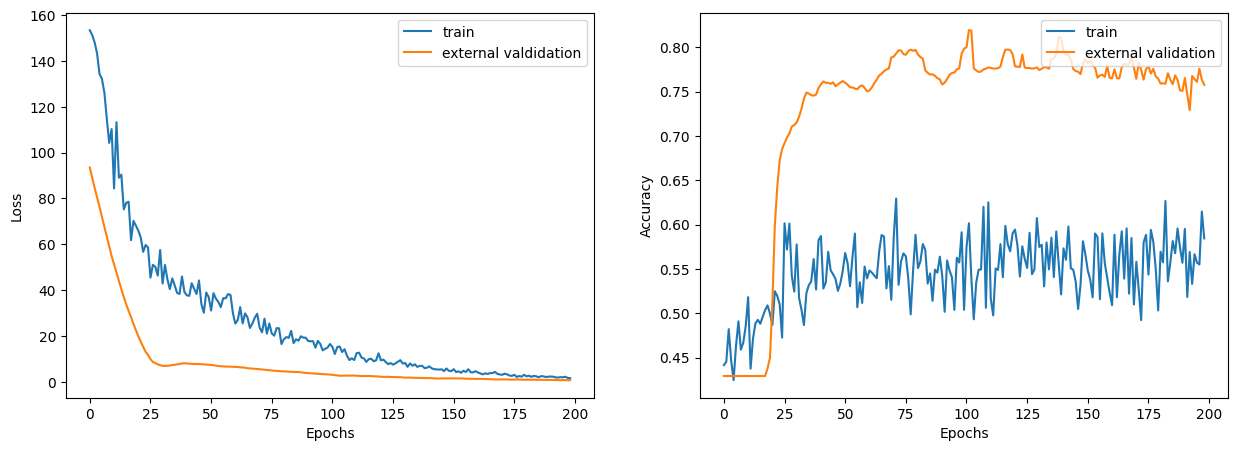

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)

os.mkdir("/mnt/durRate_layerPreproc")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")


fig1 = plt.gcf()
plt.show()

fig1.savefig("/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001.png", dpi=300)

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[137653  54118]
 [ 21519 168160]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.801711888845196
precision =  0.8648066242806524
recall =  0.7177988329830892
especificity =  0.8865504352089583
f1 =  0.7844749717190541


In [13]:
model.get_config()

{'n_labels': 2,
 'channels': 16,
 'activation': 'relu',
 'output_activation': 'softmax',
 'use_bias': False,
 'dropout_rate': 0.5,
 'l2_reg': 0.00025}

### PRUEBA 2: optimizer = Adam; learning_rate = 0.001; LayerPreprocess(GCNConv); 32 channels

In [8]:
model = GCN(n_labels=dataset.n_labels, channels=32)

optimizer = Adam(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 81.69591 - Acc: 0.51050 - Val loss: 45.13068 - Val acc: 0.36498
Ep. 1 - Loss: 78.67207 - Acc: 0.51501 - Val loss: 40.22378 - Val acc: 0.37863
Ep. 2 - Loss: 65.51897 - Acc: 0.55292 - Val loss: 35.89362 - Val acc: 0.40974
Ep. 3 - Loss: 65.26095 - Acc: 0.52379 - Val loss: 31.45751 - Val acc: 0.47792
Ep. 4 - Loss: 69.13078 - Acc: 0.47446 - Val loss: 25.93326 - Val acc: 0.56880
Ep. 5 - Loss: 67.05683 - Acc: 0.48918 - Val loss: 20.45332 - Val acc: 0.57996
Ep. 6 - Loss: 70.51943 - Acc: 0.52669 - Val loss: 15.84952 - Val acc: 0.58244
Ep. 7 - Loss: 71.50703 - Acc: 0.46178 - Val loss: 12.01093 - Val acc: 0.81869
Ep. 8 - Loss: 51.28675 - Acc: 0.56691 - Val loss: 10.20610 - Val acc: 0.75706
Ep. 9 - Loss: 48.66020 - Acc: 0.55452 - Val loss: 9.03342 - Val acc: 0.70972
Ep. 10 - Loss: 53.98252 - Acc: 0.53428 - Val loss: 8.77164 - Val acc: 0.72838
Ep. 11 - Loss: 63.96095 - Acc: 0.49602 - Val loss: 7.52416 - Val acc: 0.71363
Ep. 12 - Loss: 44.38194 - Acc: 0.51267 - Val loss: 6.35880 - Val 

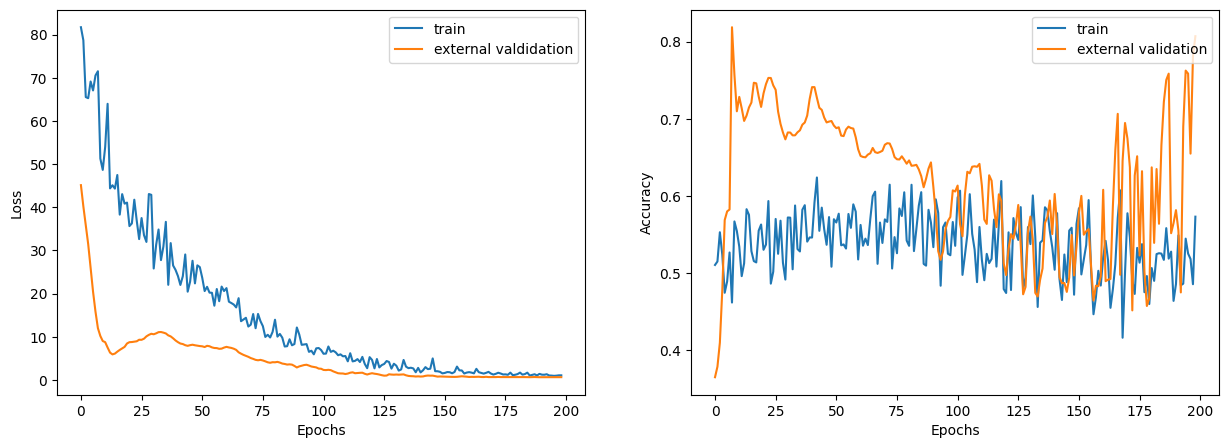

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

fig1 = plt.gcf()
plt.show()

fig1.savefig("/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_32channels.png", dpi=300)

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_32channels.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[107169  84602]
 [  6388 183291]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.761462839166339
precision =  0.9437463124245974
recall =  0.5588384062240902
especificity =  0.9663220493570717
f1 =  0.7019926112246503


### PRUEBA 3: optimizer = Adam; learning_rate = 0.001; LayerPreprocess(GCNConv); 64 channels

In [8]:
model = GCN(n_labels=dataset.n_labels, channels=64)

optimizer = Adam(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 64.39545 - Acc: 0.58821 - Val loss: 44.67672 - Val acc: 0.58196
Ep. 1 - Loss: 63.53446 - Acc: 0.54877 - Val loss: 36.72092 - Val acc: 0.58196
Ep. 2 - Loss: 55.54580 - Acc: 0.57410 - Val loss: 30.09900 - Val acc: 0.58196
Ep. 3 - Loss: 39.87684 - Acc: 0.54967 - Val loss: 24.70214 - Val acc: 0.58196
Ep. 4 - Loss: 41.95494 - Acc: 0.58375 - Val loss: 18.50911 - Val acc: 0.58196
Ep. 5 - Loss: 36.64002 - Acc: 0.57951 - Val loss: 13.83241 - Val acc: 0.52986
Ep. 6 - Loss: 39.35717 - Acc: 0.56731 - Val loss: 11.54573 - Val acc: 0.49823
Ep. 7 - Loss: 31.56219 - Acc: 0.61034 - Val loss: 10.75247 - Val acc: 0.52458
Ep. 8 - Loss: 34.74923 - Acc: 0.53173 - Val loss: 10.04842 - Val acc: 0.73196
Ep. 9 - Loss: 31.09281 - Acc: 0.54738 - Val loss: 9.42236 - Val acc: 0.74505
Ep. 10 - Loss: 31.95057 - Acc: 0.55336 - Val loss: 8.45965 - Val acc: 0.75141
Ep. 11 - Loss: 34.00859 - Acc: 0.63269 - Val loss: 7.72648 - Val acc: 0.75706
Ep. 12 - Loss: 33.24256 - Acc: 0.58845 - Val loss: 8.05515 - Val 

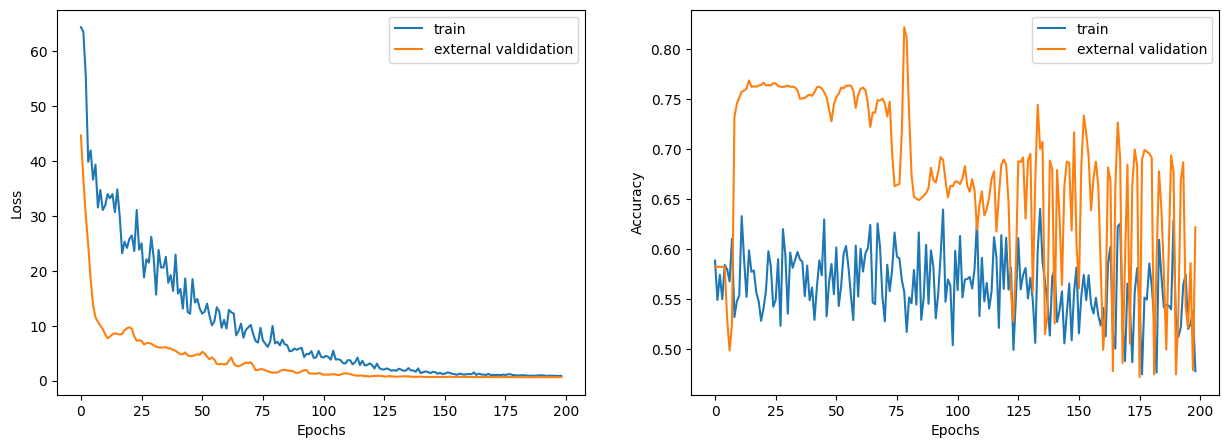

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

fig1 = plt.gcf()
plt.show()

fig1.savefig("/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_64channels.png", dpi=300)

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_64channels.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[109723  82048]
 [  7046 182633]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.7664333464412112
precision =  0.9396586422766317
recall =  0.5721563740085831
especificity =  0.9628530306465133
f1 =  0.7112400337071367


### PRUEBA 3: optimizer = Adam; learning_rate = 0.001; LayerPreprocess(GCNConv); 128 channels

In [8]:
model = GCN(n_labels=dataset.n_labels, channels=128)

optimizer = Adam(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 37.91694 - Acc: 0.46143 - Val loss: 15.99990 - Val acc: 0.42919
Ep. 1 - Loss: 34.38579 - Acc: 0.47010 - Val loss: 5.89189 - Val acc: 0.42919
Ep. 2 - Loss: 27.16961 - Acc: 0.54150 - Val loss: 3.08846 - Val acc: 0.76438
Ep. 3 - Loss: 25.23310 - Acc: 0.49845 - Val loss: 6.08691 - Val acc: 0.75508
Ep. 4 - Loss: 19.32437 - Acc: 0.60133 - Val loss: 6.91594 - Val acc: 0.75933
Ep. 5 - Loss: 19.93962 - Acc: 0.61406 - Val loss: 7.06933 - Val acc: 0.76052
Ep. 6 - Loss: 21.17162 - Acc: 0.58680 - Val loss: 6.30536 - Val acc: 0.76571
Ep. 7 - Loss: 22.83048 - Acc: 0.55674 - Val loss: 6.43459 - Val acc: 0.76587
Ep. 8 - Loss: 25.87815 - Acc: 0.51801 - Val loss: 6.70675 - Val acc: 0.76451
Ep. 9 - Loss: 20.72194 - Acc: 0.62323 - Val loss: 6.68292 - Val acc: 0.75510
Ep. 10 - Loss: 19.75828 - Acc: 0.59951 - Val loss: 6.36096 - Val acc: 0.71474
Ep. 11 - Loss: 19.20036 - Acc: 0.52952 - Val loss: 5.82228 - Val acc: 0.71483
Ep. 12 - Loss: 17.75742 - Acc: 0.53392 - Val loss: 5.38302 - Val acc: 0.7

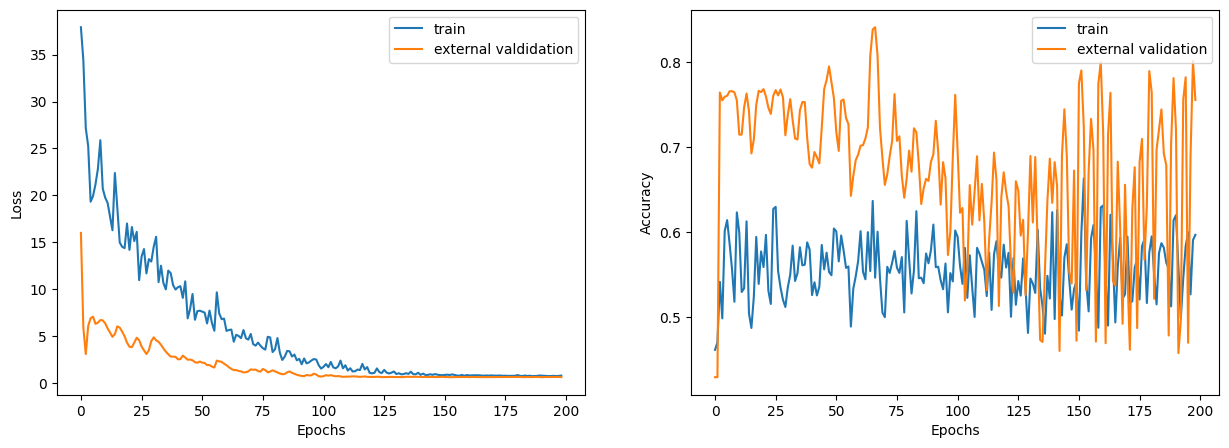

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

fig1 = plt.gcf()
plt.show()

fig1.savefig("/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_128channels.png", dpi=300)

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/durRate_layerPreproc/durRate_layerPreprocess_adam_0.001_128channels.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[104803  86968]
 [  3980 185699]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.7615729453401494
precision =  0.9634134009909636
recall =  0.5465007743610869
especificity =  0.9790171816595405
f1 =  0.697398803542791
